# F1 Ground Effect Turbulence Simulation

Lattice Boltzmann Method (LBM) simulation for studying aerodynamic ground effect in Formula 1 cars.

## Features
- D2Q9 lattice Boltzmann solver with BGK collision operator
- Smagorinsky subgrid-scale turbulence model
- Multiple geometry options (simple shapes to full F1 car)
- Configurable ride height for ground effect studies
- Parameter sweep functionality
- Automatic result saving and reproducibility

## Quick Start
1. Run the imports cell
2. Choose a geometry and set parameters
3. Run a single simulation or parameter sweep
4. Analyze and visualize results

---
## 1. Imports and Setup

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# LBM modules
from lbm_core import LBMSolver
from geometry import TunnelBoundaries, GeometryConfig, GeometryType, create_geometry
from aerodynamics import calculate_forces_mem, ForceMonitor, interpret_f1_forces, AeroForces
from analysis import (compute_flow_statistics, compute_energy_spectrum, 
                     analyze_spectral_slope, ConvergenceMonitor,
                     compute_vorticity, compute_q_criterion)
from visualization import (plot_velocity_field, plot_vorticity_field, 
                          plot_pressure_field, plot_force_history,
                          plot_energy_spectrum, create_summary_figure,
                          AnimationBuilder)
from experiment import (SimulationConfig, SimulationResults, 
                       ExperimentManager, ParameterSweep, quick_config)
from runner import run_simulation, run_parameter_sweep, quick_run, interactive_run

# Plot settings
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = [12, 4]

print("All modules loaded successfully!")
print("\nAvailable geometries:")
for g in GeometryType:
    print(f"  - {g.value}")

All modules loaded successfully!

Available geometries:
  - triangle
  - rectangle
  - cylinder
  - naca_airfoil
  - f1_wing_simple
  - f1_car_full
  - custom


---
## 2. Geometry Preview

Visualize different geometry options before running simulations.

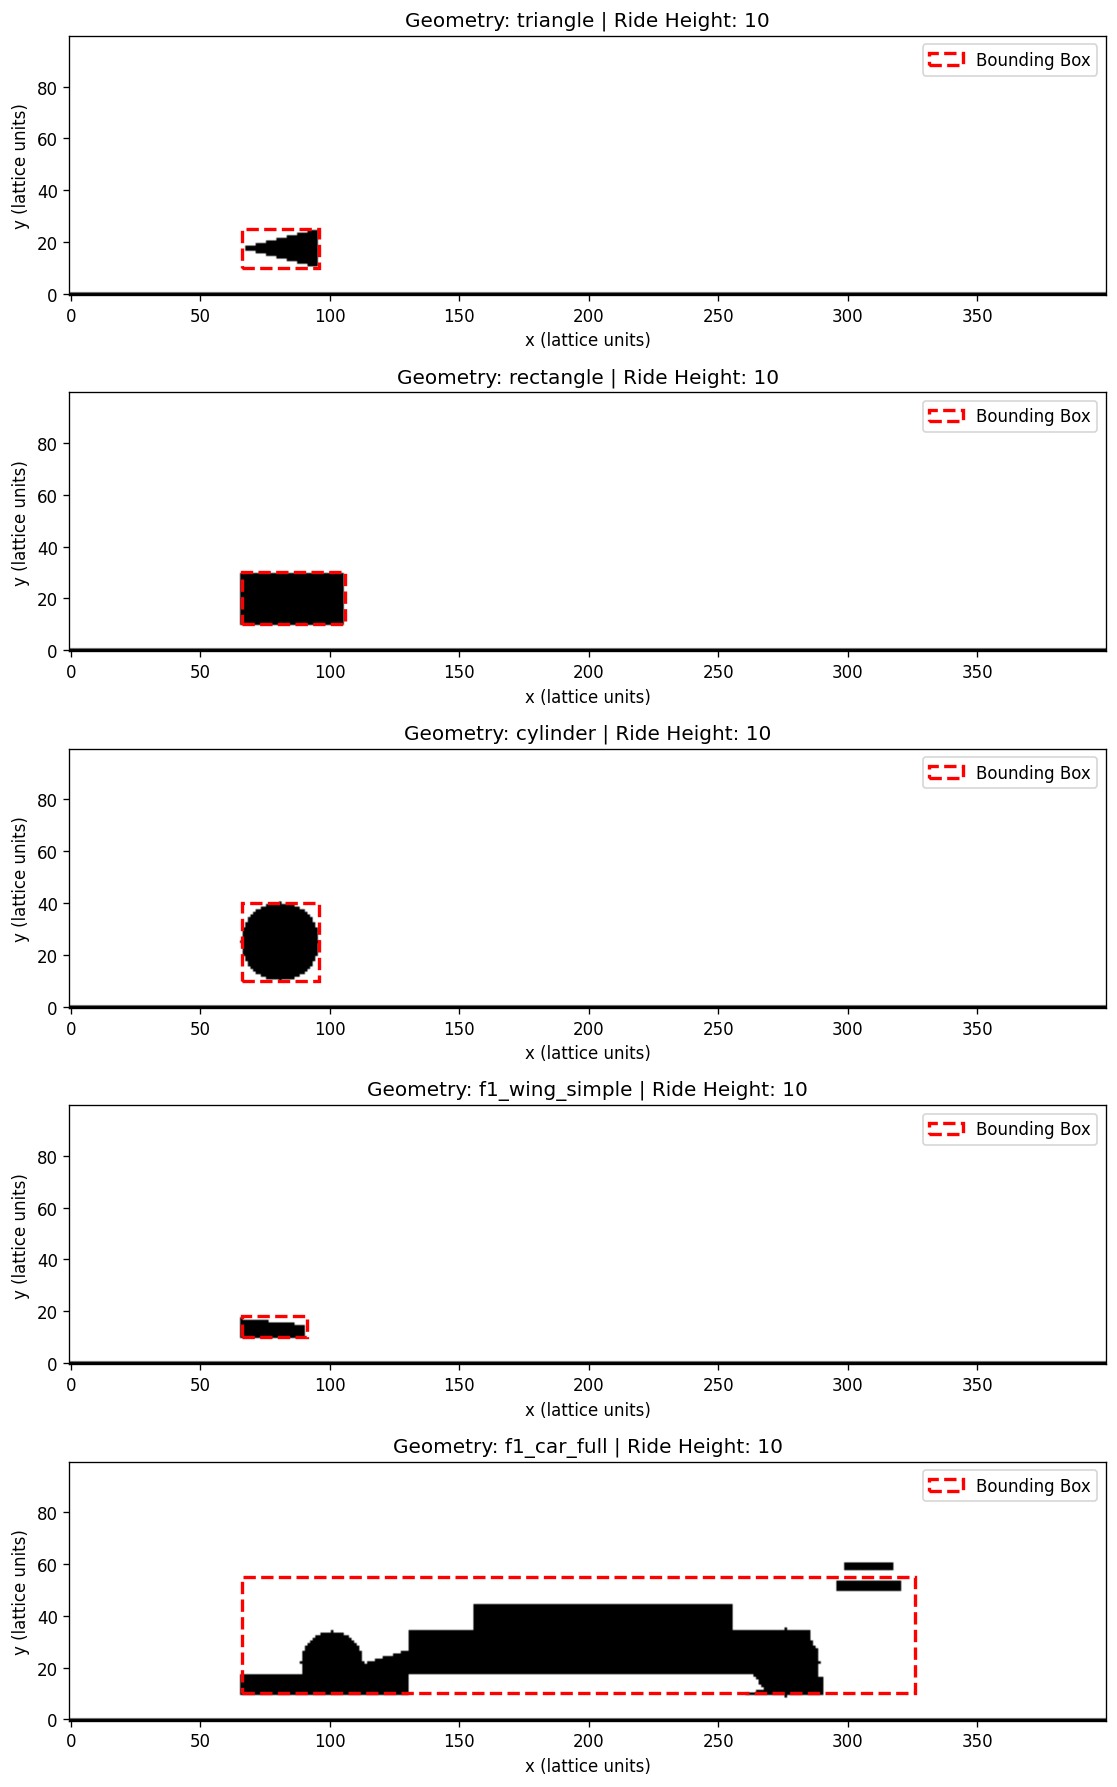

In [2]:
# Domain size
NX, NY = 400, 100

# Preview all geometry types
geometries = ['triangle', 'rectangle', 'cylinder', 'f1_wing_simple', 'f1_car_full']

fig, axes = plt.subplots(len(geometries), 1, figsize=(14, 3*len(geometries)))

for ax, geom_type in zip(axes, geometries):
    bounds = create_geometry(NX, NY, geom_type, ride_height=10)
    bounds.visualize(ax=ax)
    
plt.tight_layout()
plt.show()

### Preview Ride Height Effect

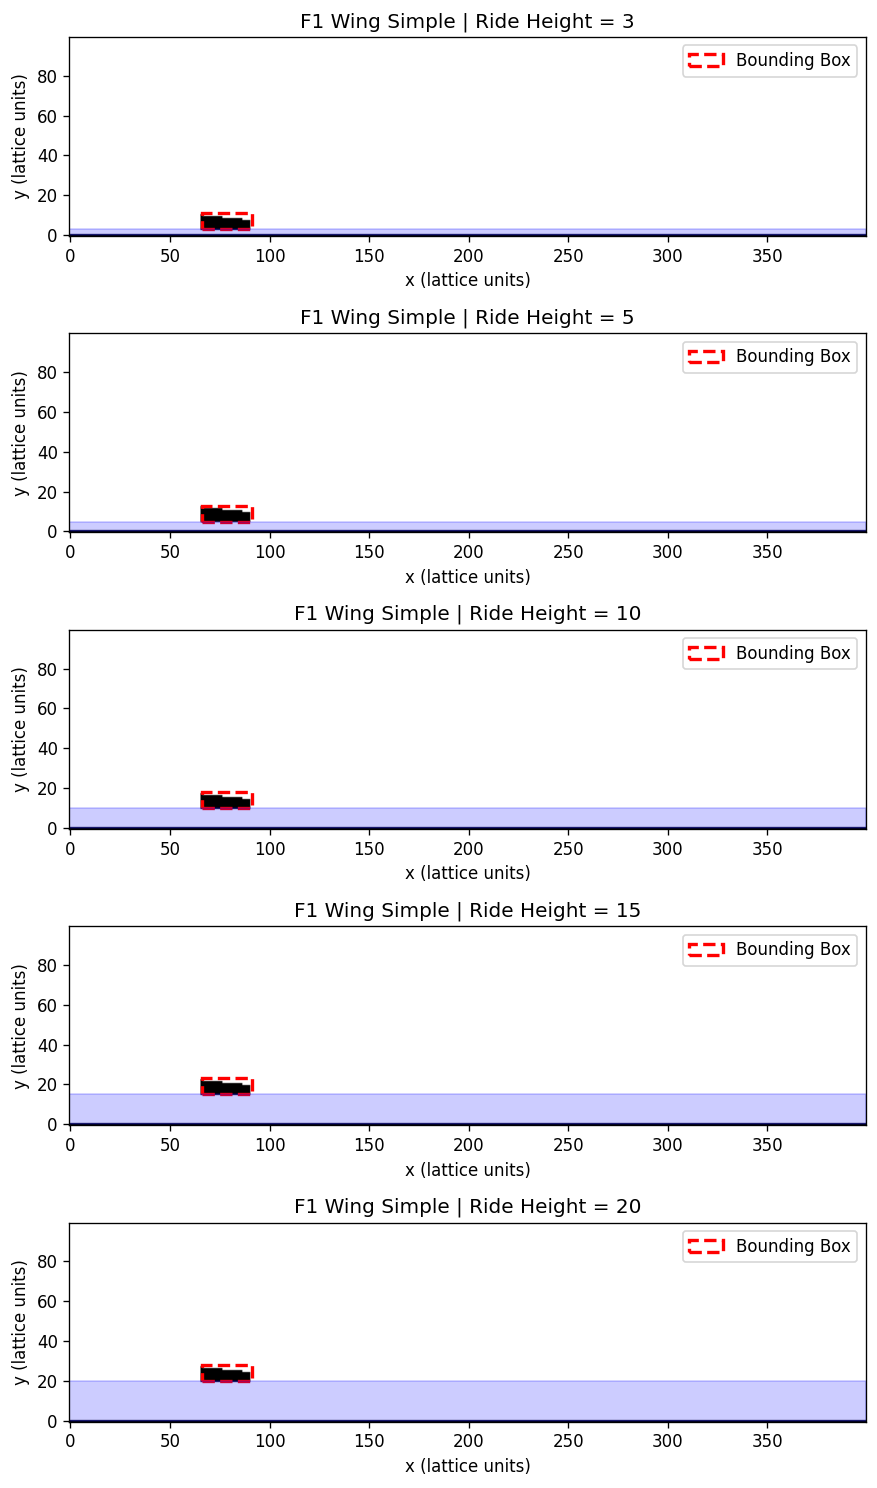

In [3]:
# Show how ride height affects geometry
ride_heights = [3, 5, 10, 15, 20]

fig, axes = plt.subplots(len(ride_heights), 1, figsize=(14, 2.5*len(ride_heights)))

for ax, rh in zip(axes, ride_heights):
    bounds = create_geometry(NX, NY, 'f1_wing_simple', ride_height=rh)
    bounds.visualize(ax=ax)
    ax.set_title(f'F1 Wing Simple | Ride Height = {rh}')
    # Show ground clearance region
    ax.axhspan(0, rh, alpha=0.2, color='blue', label='Ground clearance')
    
plt.tight_layout()
plt.show()

---
## 3. Single Simulation Run

Configure and run a single simulation with detailed output.

In [4]:
# =============================================================================
# SIMULATION PARAMETERS - MODIFY THESE
# =============================================================================

config = SimulationConfig(
    # Domain
    nx=400,
    ny=100,
    
    # Physics
    reynolds=1000,           # Reynolds number (for higher Re, increase ny or decrease u_inlet)
    u_inlet=0.08,            # Inlet velocity (keep < 0.1 for stability)
    cs_smag=0.15,            # Smagorinsky constant (0 = disable turbulence model)
    
    # Geometry - OPTIONS:
    # 'triangle', 'rectangle', 'cylinder', 'naca_airfoil', 'f1_wing_simple', 'f1_car_full'
    geometry_type='f1_wing_simple',
    ride_height=5,           # Distance from ground (lattice units)
    geometry_scale=1.0,      # Scale factor for geometry
    ground_type='no_slip',   # 'no_slip' or 'moving'
    
    # Simulation
    total_steps=5000,        # Total simulation steps
    output_interval=50,      # Steps between force recordings
    
    # Convergence
    convergence_window=500,
    convergence_tolerance=0.02,
    
    # Output
    save_flow_fields=True,
    save_animation=False,    # Set True to generate animation (slower)
    
    # Metadata
    name='test_simulation',
    description='Initial test run'
)

print("Configuration:")
print(f"  Reynolds: {config.reynolds}")
print(f"  Geometry: {config.geometry_type}")
print(f"  Ride Height: {config.ride_height}")
print(f"  Steps: {config.total_steps}")

Configuration:
  Reynolds: 1000
  Geometry: f1_wing_simple
  Ride Height: 5
  Steps: 5000


In [5]:
# Run simulation (with saving)
manager = ExperimentManager('results')
exp_dir = manager.create_experiment_dir(config.name)

results = run_simulation(config, exp_dir=exp_dir, verbose=True)

print(f"\nResults saved to: {exp_dir}")

Starting simulation: test_simulation
  Geometry: f1_wing_simple
  Reynolds: 1000
  Ride Height: 5
  Steps: 5000
Note: Operating near stability limit (tau=0.5120).
  Step      0/5000 | Drag:  -2.4800 | Lift:  -0.0800
  Step    500/5000 | Drag:  -0.5106 | Lift:  -0.1958
  Step   1000/5000 | Drag:  -0.4166 | Lift:  -0.1483
  Step   1500/5000 | Drag:  -0.5318 | Lift:  -0.0331
  Step   2000/5000 | Drag:  -0.4295 | Lift:  -0.0348
  Step   2500/5000 | Drag:  -0.4306 | Lift:  -0.0244
  Step   3000/5000 | Drag:  -0.4103 | Lift:  -0.0317
  Step   3500/5000 | Drag:  -0.4044 | Lift:  -0.0318
  Step   4000/5000 | Drag:  -0.3993 | Lift:  -0.0329
  Step   4500/5000 | Drag:  -0.3958 | Lift:  -0.0341

Simulation Results: test_simulation
Geometry: f1_wing_simple
Reynolds: 1000
Ride Height: 5

--- Aerodynamic Forces ---
Mean Drag:      -0.499430 (Cd = -19.5090)
Mean Lift:      -0.062325 (Cl = -2.4346)
Downforce:       0.062325
Std Drag:        0.286903
Std Lift:        0.059525

--- Convergence ---
Conve

### Quick Run (No Saving)
For fast iteration and testing:

In [ ]:
# Quick run without saving (for testing)
results = quick_run(
    reynolds=1000,
    ride_height=5,
    geometry='f1_wing_simple',
    steps=2000,
    save=False
)

---
## 4. Manual Simulation with Live Visualization

For detailed control and interactive exploration.

  Tip: Use turbulence_model='effective_re' for high-Re simulation.
LBMSolver(nx=400, ny=100, Re_nominal=10000, Re_eff=3e+03, model=smagorinsky)


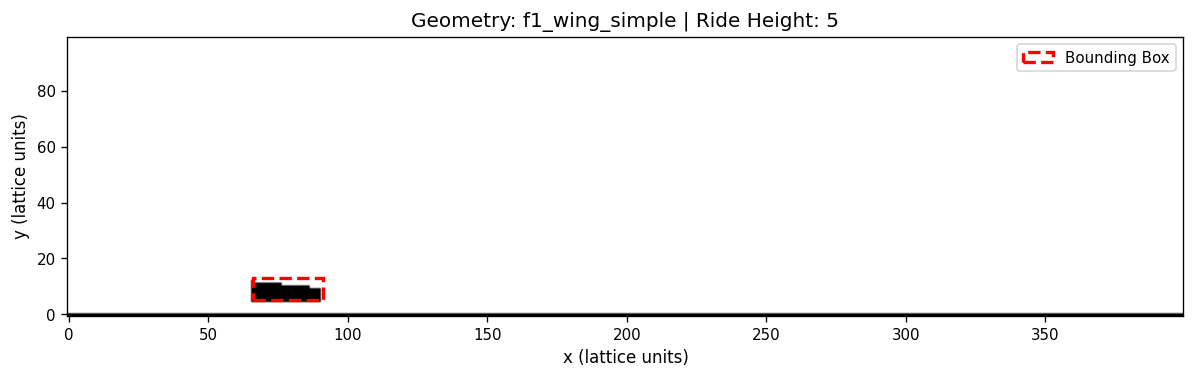

In [26]:
# Setup simulation manually for more control
NX, NY = 400, 100
REYNOLDS = 10000
U_INLET = 0.1
RIDE_HEIGHT = 5
TOTAL_STEPS = 5000

# Create solver
solver = LBMSolver(NX, NY, REYNOLDS, U_INLET, cs_smag=0.15)
print(solver)

# Create geometry
bounds = create_geometry(NX, NY, 'f1_wing_simple', ride_height=RIDE_HEIGHT)

# Show initial geometry
fig, ax = plt.subplots(figsize=(12, 4))
bounds.visualize(ax=ax)
plt.show()

In [27]:
# Run simulation with progress tracking
force_monitor = ForceMonitor()

print("Running simulation...")
for step in range(TOTAL_STEPS):
    # LBM step
    solver.collide_and_stream(bounds.mask)
    bounds.apply_inlet_outlet(solver)
    
    # Record forces every 50 steps
    if step % 50 == 0:
        forces = calculate_forces_mem(solver, bounds)
        force_monitor.record(step, forces)
        
    # Progress output every 500 steps
    if step % 500 == 0:
        print(f"  Step {step:>5}/{TOTAL_STEPS}")

print("Done!")

# Final force analysis
mean_forces = force_monitor.get_mean_forces()
interpret_f1_forces(mean_forces)

Running simulation...
  Step     0/5000
  Step   500/5000
  Step  1000/5000
  Step  1500/5000
  Step  2000/5000
  Step  2500/5000
  Step  3000/5000
  Step  3500/5000
  Step  4000/5000
  Step  4500/5000
Done!
=== Aerodynamic Analysis ===
  Drag Force:        -0.8486
  Lift Force:        -0.0618
  Drag Coeff Cd:    -21.2156
  Lift Coeff Cl:     -1.5439
  L/D Ratio:          0.0728

  ✓ DOWNFORCE generated: 0.0618


{'has_downforce': True,
 'downforce_magnitude': 0.061755058512687644,
 'drag_magnitude': -0.8486247434059839,
 'efficiency': 0.07277074937130827,
 'ground_effect_active': False}

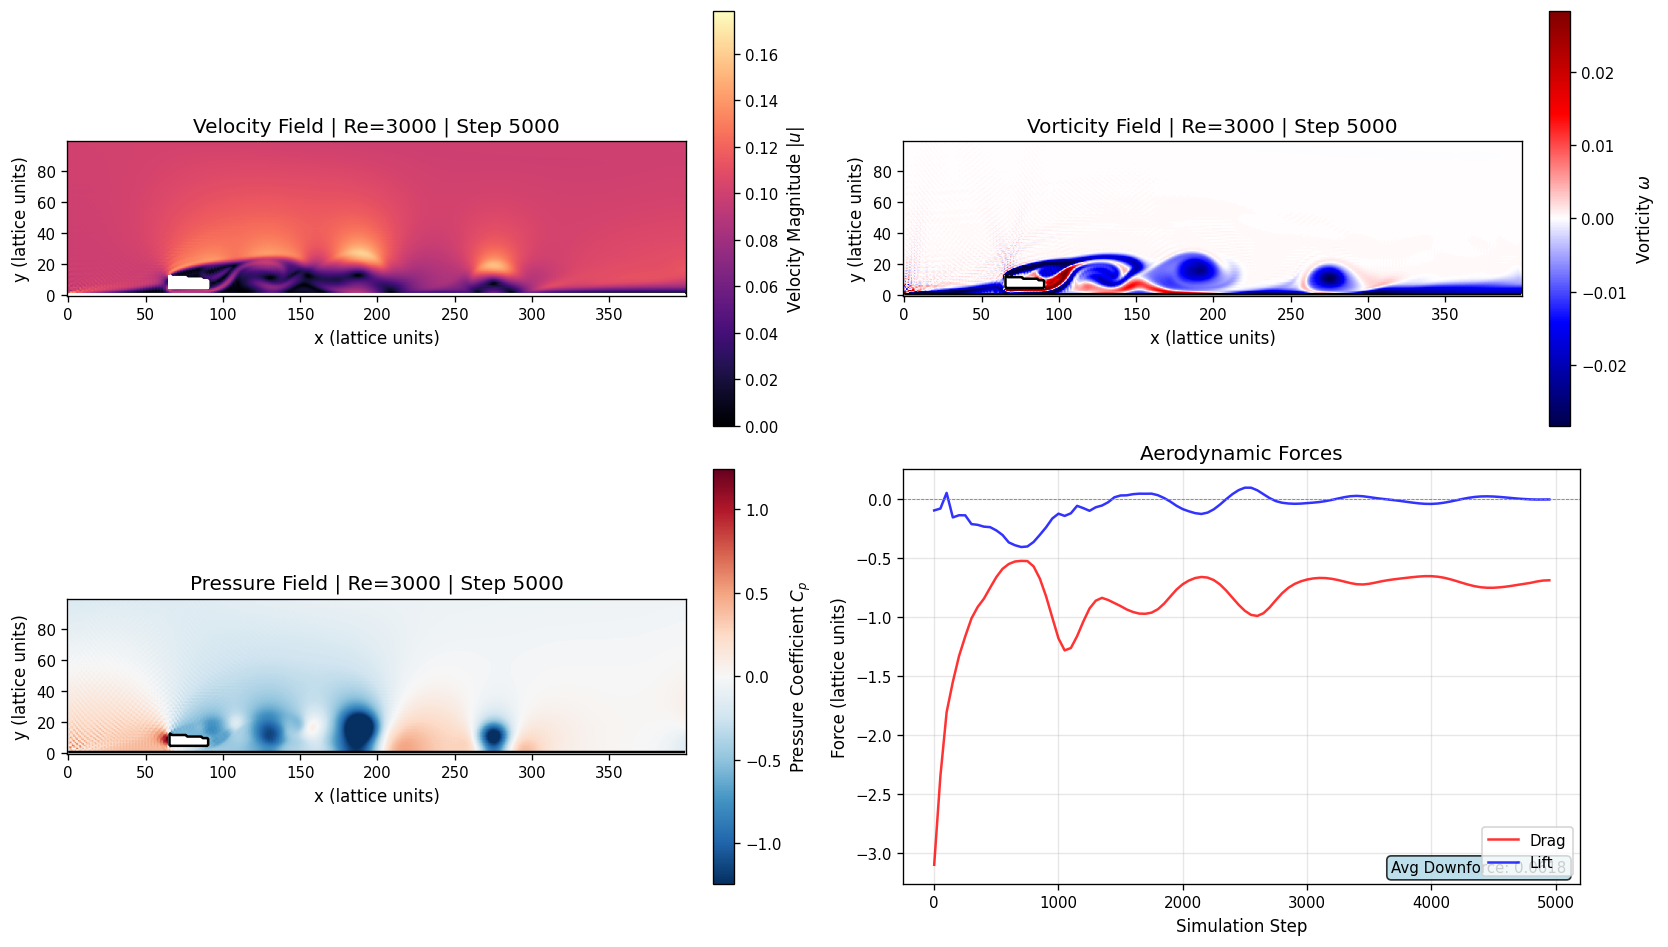

In [28]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Velocity
plot_velocity_field(solver, bounds, ax=axes[0, 0], streamlines=False)

# Vorticity
plot_vorticity_field(solver, bounds, ax=axes[0, 1])

# Pressure
plot_pressure_field(solver, bounds, ax=axes[1, 0])

# Forces
plot_force_history(force_monitor, ax=axes[1, 1])

plt.tight_layout()
plt.show()

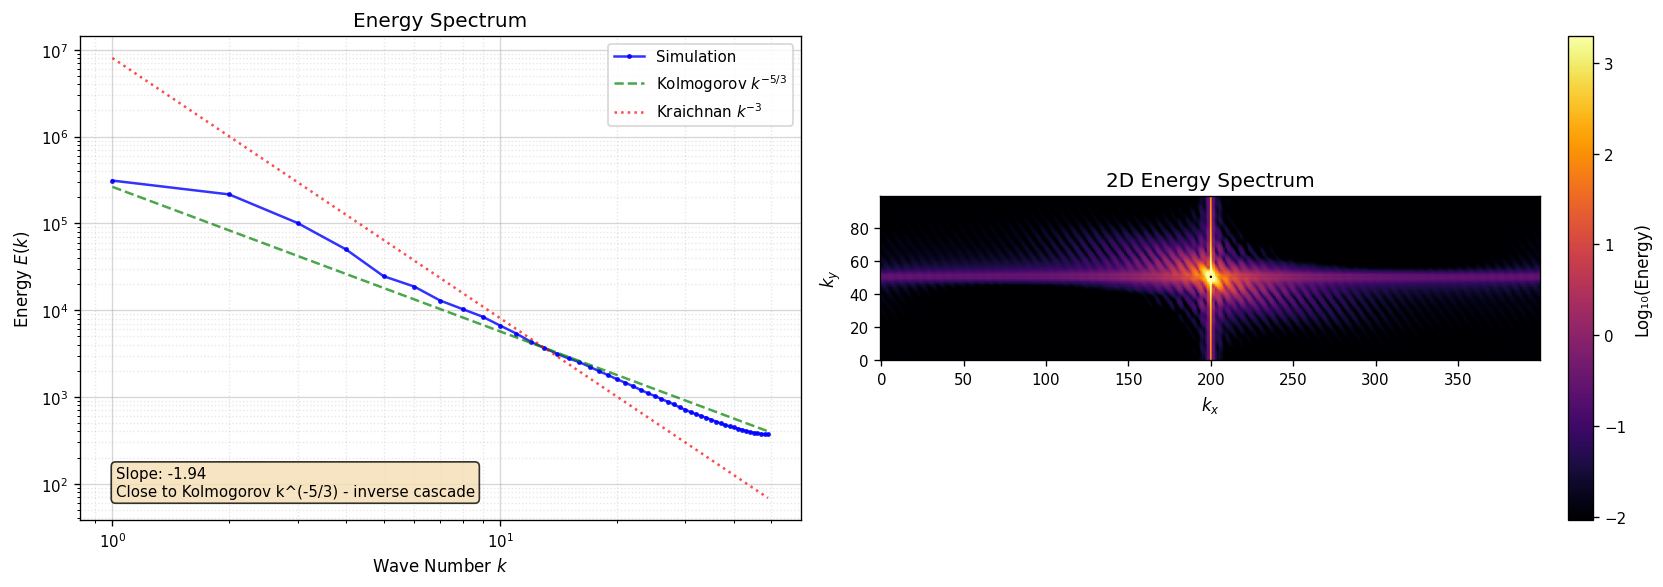


Spectral Analysis:
  Fitted slope: -1.944
  R-squared: 1.000
  Interpretation: Close to Kolmogorov k^(-5/3) - inverse cascade


In [12]:
# Energy spectrum analysis
k, E_k, fft_2d = compute_energy_spectrum(solver.u[:,:,0], solver.u[:,:,1])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1D spectrum
plot_energy_spectrum(k, E_k, ax=axes[0])

# Analyze slope
slope_analysis = analyze_spectral_slope(k, E_k)
axes[0].text(0.05, 0.05, f"Slope: {slope_analysis['slope']:.2f}\n{slope_analysis['comparison']}",
            transform=axes[0].transAxes, fontsize=9,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 2D spectrum
from visualization import plot_fft_2d
plot_fft_2d(fft_2d, ax=axes[1])

plt.tight_layout()
plt.show()

print(f"\nSpectral Analysis:")
print(f"  Fitted slope: {slope_analysis['slope']:.3f}")
print(f"  R-squared: {slope_analysis['r_squared']:.3f}")
print(f"  Interpretation: {slope_analysis['comparison']}")

---
## 5. Parameter Sweep

Systematically explore the effect of ride height and Reynolds number on aerodynamic performance.

In [ ]:
# =============================================================================
# PARAMETER SWEEP CONFIGURATION
# =============================================================================

# Base configuration (values not being swept)
base_config = SimulationConfig(
    nx=400,
    ny=100,
    u_inlet=0.1,
    cs_smag=0.15,
    geometry_type='f1_wing_simple',
    ground_type='no_slip',
    total_steps=4000,
    output_interval=50,
    save_flow_fields=False,  # Disabled to save disk space
    save_animation=False
)

# Parameters to sweep
sweep_params = {
    'ride_height': [3, 5, 7, 10, 15],
    'reynolds': [500, 1000, 2000]
}

print(f"Parameter Sweep Configuration:")
print(f"  Ride heights: {sweep_params['ride_height']}")
print(f"  Reynolds numbers: {sweep_params['reynolds']}")
print(f"  Total combinations: {len(sweep_params['ride_height']) * len(sweep_params['reynolds'])}")

Parameter Sweep Configuration:
  Ride heights: [3, 5, 7, 10, 15]
  Reynolds numbers: [500, 1000, 2000]
  Total combinations: 15


In [11]:
# Run parameter sweep (this will take a while!)
sweep, results = run_parameter_sweep(
    base_config,
    sweep_params,
    results_dir='results/sweep_rh_re',
    verbose=True
)

Starting parameter sweep: 15 configurations
Parameters: ['ride_height', 'reynolds']
--------------------------------------------------

[1/15] rid3_rey500
Results saved to results\sweep_rh_re\rid3_rey500

[2/15] rid3_rey1000
Note: Operating near stability limit (tau=0.5150).
Results saved to results\sweep_rh_re\rid3_rey1000

[3/15] rid3_rey2000
Note: Operating near stability limit (tau=0.5075).
Results saved to results\sweep_rh_re\rid3_rey2000

[4/15] rid5_rey500
Results saved to results\sweep_rh_re\rid5_rey500

[5/15] rid5_rey1000
Note: Operating near stability limit (tau=0.5150).
Results saved to results\sweep_rh_re\rid5_rey1000

[6/15] rid5_rey2000
Note: Operating near stability limit (tau=0.5075).
Results saved to results\sweep_rh_re\rid5_rey2000

[7/15] rid7_rey500
Results saved to results\sweep_rh_re\rid7_rey500

[8/15] rid7_rey1000
Note: Operating near stability limit (tau=0.5150).
Results saved to results\sweep_rh_re\rid7_rey1000

[9/15] rid7_rey2000
Note: Operating near stabil

In [12]:
# Analyze sweep results
df = sweep.get_results_dataframe()
print(df.to_string())

             name  reynolds  ride_height        geometry  mean_drag  mean_lift    mean_cd   mean_cl  downforce  converged  efficiency
0     rid3_rey500       500            3  f1_wing_simple  -0.196876  -0.167258  -4.921912 -4.181450   0.167258      False         NaN
1    rid3_rey1000      1000            3  f1_wing_simple  -0.316514  -0.156006  -7.912862 -3.900161   0.156006      False         NaN
2    rid3_rey2000      2000            3  f1_wing_simple  -0.553415  -0.103754 -13.835380 -2.593853   0.103754      False         NaN
3     rid5_rey500       500            5  f1_wing_simple  -0.429529  -0.152643 -10.738221 -3.816066   0.152643      False         NaN
4    rid5_rey1000      1000            5  f1_wing_simple  -0.636061  -0.092693 -15.901515 -2.317320   0.092693      False         NaN
5    rid5_rey2000      2000            5  f1_wing_simple  -0.831030  -0.075448 -20.775744 -1.886197   0.075448      False         NaN
6     rid7_rey500       500            7  f1_wing_simple  -0.5

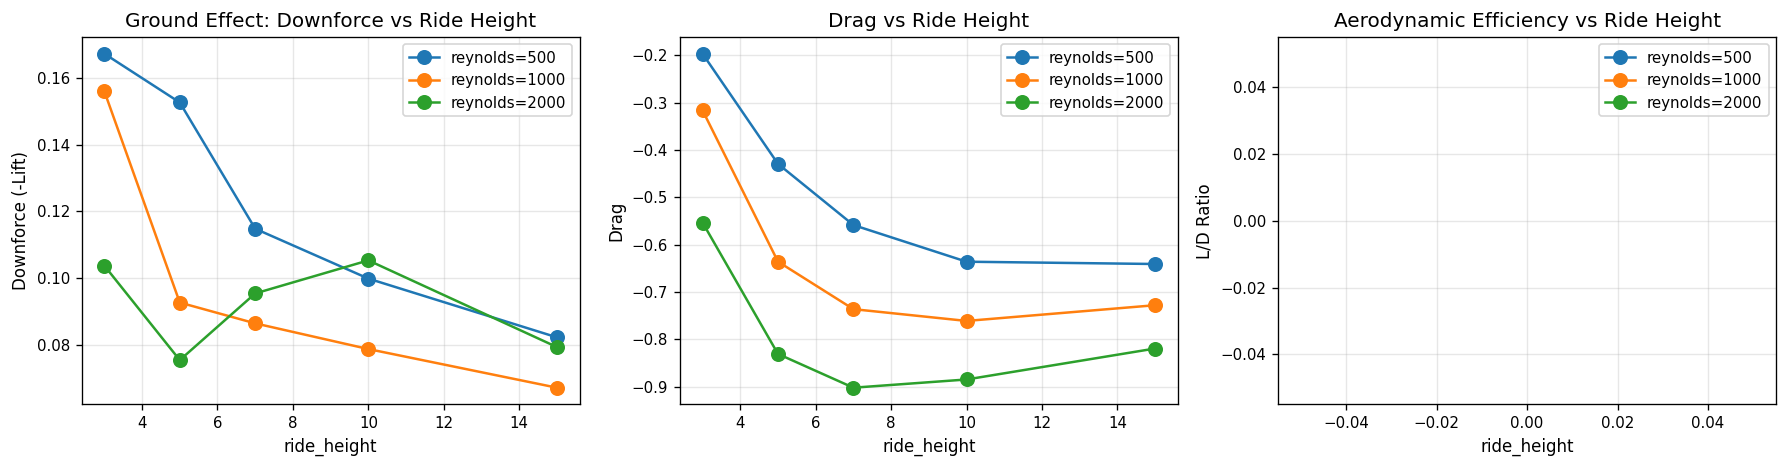

In [13]:
# Plot sweep results
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Downforce vs Ride Height
sweep.plot_sweep_results('ride_height', 'downforce', hue_param='reynolds', ax=axes[0])
axes[0].set_ylabel('Downforce (-Lift)')
axes[0].set_title('Ground Effect: Downforce vs Ride Height')

# Drag vs Ride Height
sweep.plot_sweep_results('ride_height', 'mean_drag', hue_param='reynolds', ax=axes[1])
axes[1].set_ylabel('Drag')
axes[1].set_title('Drag vs Ride Height')

# Efficiency vs Ride Height
sweep.plot_sweep_results('ride_height', 'efficiency', hue_param='reynolds', ax=axes[2])
axes[2].set_ylabel('L/D Ratio')
axes[2].set_title('Aerodynamic Efficiency vs Ride Height')

plt.tight_layout()
plt.show()

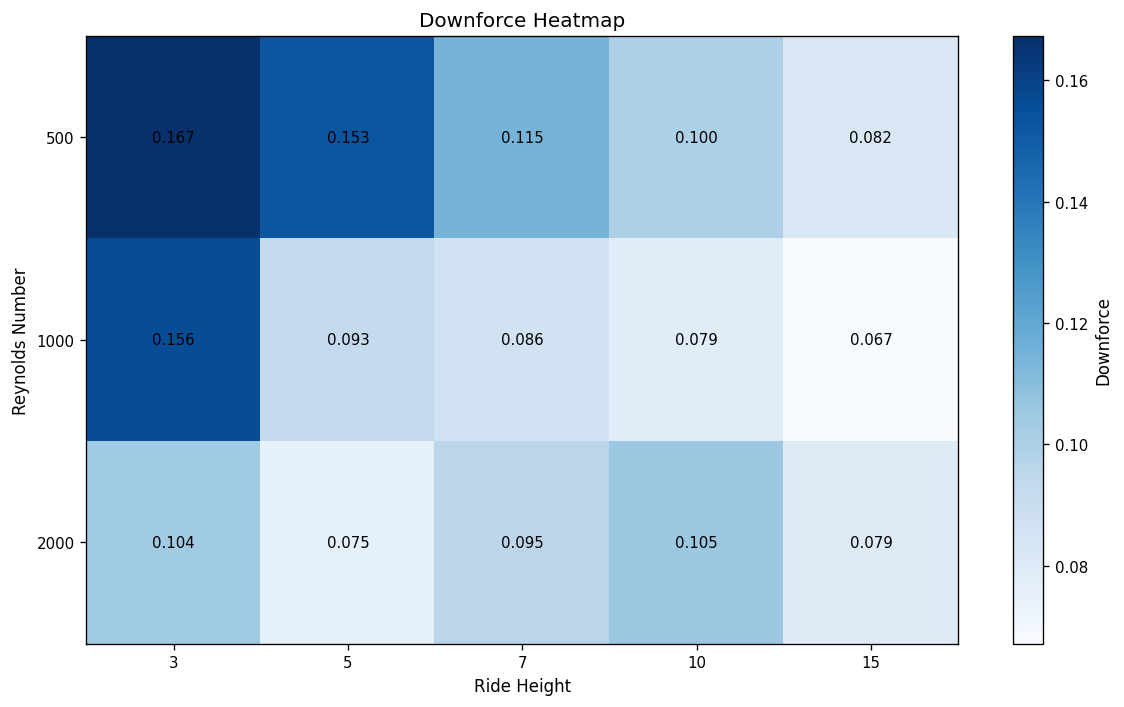

In [14]:
# Heatmap of results
import pandas as pd

# Pivot for heatmap
pivot_downforce = df.pivot(index='reynolds', columns='ride_height', values='downforce')

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(pivot_downforce.values, cmap='Blues', aspect='auto')

ax.set_xticks(range(len(pivot_downforce.columns)))
ax.set_xticklabels(pivot_downforce.columns)
ax.set_yticks(range(len(pivot_downforce.index)))
ax.set_yticklabels(pivot_downforce.index)

ax.set_xlabel('Ride Height')
ax.set_ylabel('Reynolds Number')
ax.set_title('Downforce Heatmap')

plt.colorbar(im, ax=ax, label='Downforce')

# Add values in cells
for i in range(len(pivot_downforce.index)):
    for j in range(len(pivot_downforce.columns)):
        text = ax.text(j, i, f'{pivot_downforce.values[i, j]:.3f}',
                       ha='center', va='center', color='black', fontsize=9)

plt.tight_layout()
plt.show()

---
## 6. Load and Compare Previous Results

Load saved experiments for analysis and comparison.

In [15]:
# List all saved experiments
manager = ExperimentManager('results')
experiments = manager.list_experiments()

print("Saved experiments:")
for exp in experiments:
    print(f"  - {exp}")

Saved experiments:
  - sweep_rh_re
  - test_simulation
  - test_simulation_20260126_102138


Simulation Results: test_simulation
Geometry: f1_wing_simple
Reynolds: 1000
Ride Height: 5

--- Aerodynamic Forces ---
Mean Drag:      -0.499430 (Cd = -19.5090)
Mean Lift:      -0.062325 (Cl = -2.4346)
Downforce:       0.062325
Std Drag:        0.286903
Std Lift:        0.059525

--- Convergence ---
Converged:     No
Final Step:    5000

--- Performance ---
Wall Time:     124.2 s
Speed:         40.3 steps/s


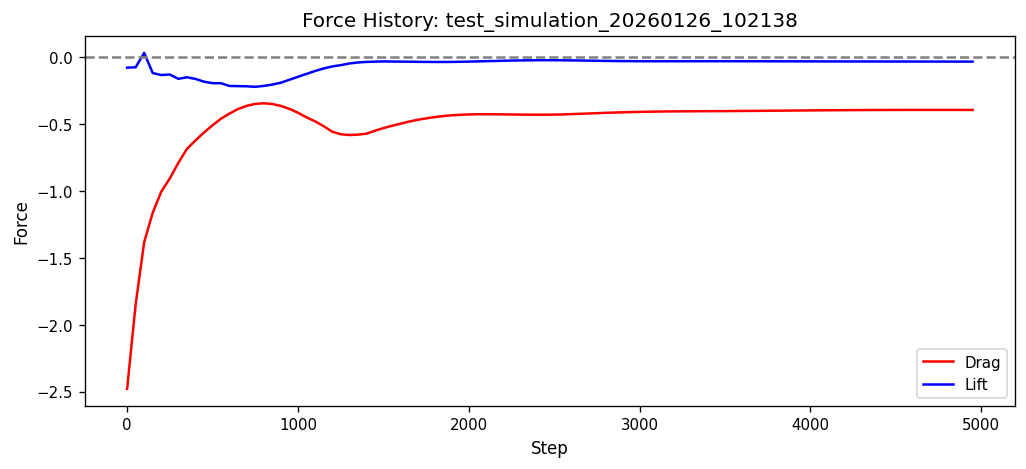

In [17]:
# Load a specific experiment
if experiments:
    exp_name = experiments[2]  # Change to desired experiment
    loaded_results = manager.load_results(exp_name)
    
    print(loaded_results.summary_string())
    
    # Plot force history if available
    if loaded_results.force_history is not None:
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(loaded_results.force_history['steps'], 
               loaded_results.force_history['drag'], 'r-', label='Drag')
        ax.plot(loaded_results.force_history['steps'], 
               loaded_results.force_history['lift'], 'b-', label='Lift')
        ax.axhline(0, color='gray', linestyle='--')
        ax.legend()
        ax.set_xlabel('Step')
        ax.set_ylabel('Force')
        ax.set_title(f'Force History: {exp_name}')
        plt.show()

---
## 7. Advanced: Full F1 Car Simulation

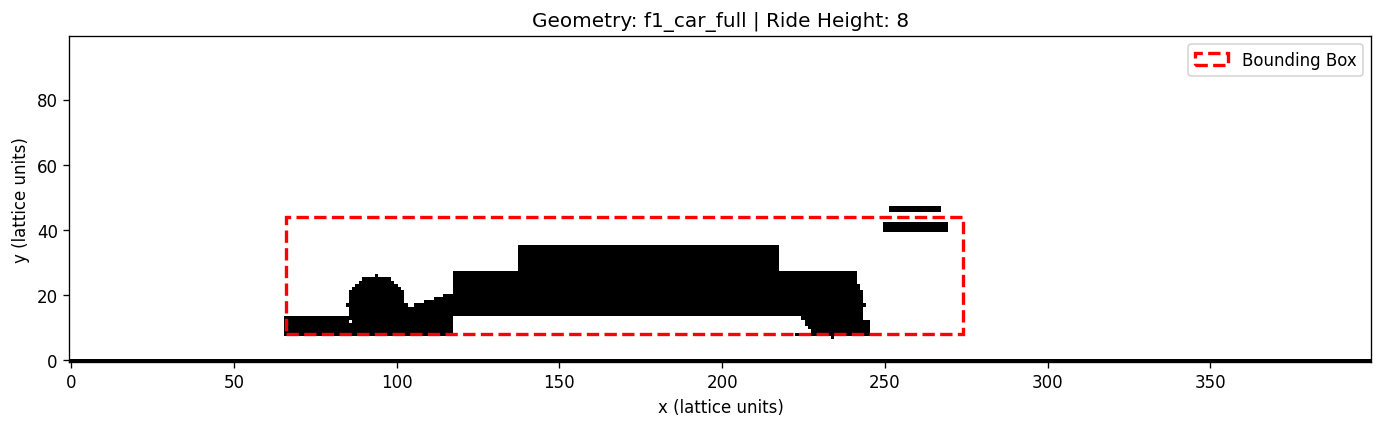

In [ ]:
# Full F1 car simulation (requires larger domain)
config_f1 = SimulationConfig(
    nx=400,
    ny=100,
    reynolds=5000,
    u_inlet=0.08,  # Slightly lower for stability at high Re
    cs_smag=0.15,
    geometry_type='f1_car_full',
    ride_height=8,
    geometry_scale=0.8,  # Scale down to fit domain
    ground_type='moving',  # Realistic moving ground
    total_steps=6000,
    output_interval=100,
    save_flow_fields=True,
    name='f1_full_car'
)


# Preview geometry
bounds_preview = create_geometry(
    config_f1.nx, config_f1.ny,
    config_f1.geometry_type,
    ride_height=config_f1.ride_height,
    scale=config_f1.geometry_scale
)

fig, ax = plt.subplots(figsize=(14, 4))
bounds_preview.visualize(ax=ax)
plt.show()

In [3]:
# Run full F1 car simulation (uncomment to run - takes longer!)
manager = ExperimentManager('results')
exp_dir = manager.create_experiment_dir(config_f1.name)
results_f1 = run_simulation(config_f1, exp_dir=exp_dir, verbose=True)

Starting simulation: f1_full_car
  Geometry: f1_car_full
  Reynolds: 5000
  Ride Height: 8
  Steps: 6000
  Tip: Use turbulence_model='effective_re' for high-Re simulation.
  Step      0/6000 | Drag: -18.9600 | Lift:  -0.0267
  Step   1000/6000 | Drag:  -4.6012 | Lift:  -0.0700
  Step   2000/6000 | Drag:  -3.3377 | Lift:  -0.0300
  Step   3000/6000 | Drag:  -3.0217 | Lift:   0.3157
  Step   4000/6000 | Drag:  -2.7833 | Lift:   0.3102
  Step   5000/6000 | Drag:  -2.9150 | Lift:   0.4039

Simulation Results: f1_full_car
Geometry: f1_car_full
Reynolds: 5000
Ride Height: 8

--- Aerodynamic Forces ---
Mean Drag:      -3.878902 (Cd = -33.6710)
Mean Lift:       0.154823 (Cl = 1.3439)
LIFT:            0.154823
Std Drag:        2.451873
Std Lift:        0.259772

--- Convergence ---
Converged:     No
Final Step:    6000

--- Performance ---
Wall Time:     151.9 s
Speed:         39.5 steps/s
=== Aerodynamic Analysis ===
  Drag Force:        -3.8789
  Lift Force:         0.1548
  Drag Coeff Cd:   

---
## 8. High Reynolds Number Simulation (Re ~ 10⁷)

Real F1 cars operate at Re ≈ 10,000,000. Direct simulation at this Re would require
millions of grid points. Instead, we use the **Effective Reynolds Model** which:

1. Runs at a numerically stable grid Reynolds number
2. Adds turbulent viscosity that mimics high-Re physics
3. Produces representative flow patterns and force coefficients

This is similar to RANS (Reynolds-Averaged Navier-Stokes) approaches used in industry CFD.

In [4]:
# High Reynolds Number Configuration
config_high_re = SimulationConfig(
    # Domain (larger for better results)
    nx=500,
    ny=120,
    
    # Physics - TARGET Re = 10 million!
    reynolds=10_000_000,         # This is the target Re
    u_inlet=0.08,
    
    # KEY: Use effective_re turbulence model
    turbulence_model='effective_re',
    cs_smag=0.1,
    effective_re_target=10_000_000,  # Explicitly set target
    
    # Geometry
    geometry_type='f1_car_full',
    ride_height=8,
    geometry_scale=0.7,
    ground_type='moving',  # Moving ground for realism
    
    # Simulation
    total_steps=8000,
    output_interval=100,
    
    name='f1_high_re_10M'
)

print("High-Re Configuration:")
print(f"  Target Reynolds: {config_high_re.reynolds:,.0f}")
print(f"  Turbulence Model: {config_high_re.turbulence_model}")
print(f"  Geometry: {config_high_re.geometry_type}")

High-Re Configuration:
  Target Reynolds: 10,000,000
  Turbulence Model: effective_re
  Geometry: f1_car_full


In [5]:
# Run high-Re simulation
# Note: The solver will print info about the effective Re scaling

from lbm_core import LBMSolver

# Create solver to see the scaling info
solver_test = LBMSolver(
    config_high_re.nx, config_high_re.ny,
    reynolds=config_high_re.reynolds,
    u_inlet=config_high_re.u_inlet,
    turbulence_model=config_high_re.turbulence_model,
    effective_re_target=config_high_re.effective_re_target
)
print(f"\nSolver: {solver_test}")

High-Re Mode: Simulating at Re_grid=960 with turbulence model representing Re_eff=1e+07

Solver: LBMSolver(nx=500, ny=120, Re_nominal=10000000, Re_eff=1e+07, model=effective_re)


In [6]:
# Full high-Re simulation (uncomment to run)
# This takes longer but gives realistic high-speed aerodynamic behavior

manager = ExperimentManager('results')
exp_dir = manager.create_experiment_dir(config_high_re.name)
results_high_re = run_simulation(config_high_re, exp_dir=exp_dir, verbose=True)

Starting simulation: f1_high_re_10M
  Geometry: f1_car_full
  Reynolds: 10000000
  Ride Height: 8
  Steps: 8000
High-Re Mode: Simulating at Re_grid=960 with turbulence model representing Re_eff=1e+07
  Step      0/8000 | Drag: -16.4000 | Lift:  -0.0800
  Step   1000/8000 | Drag:  -1.4359 | Lift:  -0.2405
  Step   2000/8000 | Drag:  -1.2727 | Lift:  -0.1830
  Step   3000/8000 | Drag:  -1.1666 | Lift:  -0.0670
  Step   4000/8000 | Drag:  -1.1021 | Lift:   0.1761
  Step   5000/8000 | Drag:  -1.0934 | Lift:   0.4677
  Step   6000/8000 | Drag:  -1.0927 | Lift:   0.7139
  Step   7000/8000 | Drag:  -1.1081 | Lift:   0.9258

Simulation Results: f1_high_re_10M
Geometry: f1_car_full
Reynolds: 10000000
Ride Height: 8

--- Aerodynamic Forces ---
Mean Drag:      -1.462713 (Cd = -14.7451)
Mean Lift:       0.293101 (Cl = 2.9546)
LIFT:            0.293101
Std Drag:        1.731301
Std Lift:        0.446917

--- Convergence ---
Converged:     No
Final Step:    8000

--- Performance ---
Wall Time:     3

### Understanding the Effective Re Model

| Parameter | Grid Value | Effective Value |
|-----------|------------|----------------|
| Reynolds Number | ~1,000-2,000 | 10,000,000 |
| Viscosity | Higher (stable) | Lower (modeled) |
| Turbulent Structures | Resolved at grid scale | Modeled via SGS |

The key insight is that at very high Re:
- Flow patterns become **self-similar** (independent of Re)
- Force **coefficients** (Cd, Cl) approach constant values
- Small-scale turbulence can be **modeled** rather than resolved

This is why wind tunnel tests at Re=10⁶ are valid for full-scale cars at Re=10⁷.

---
## 9. Export and Reporting

In [ ]:
# Generate comprehensive summary figure
# (Requires running a simulation first)

try:
    # Compute energy spectrum
    k, E_k, fft_2d = compute_energy_spectrum(solver.u[:,:,0], solver.u[:,:,1])
    
    # Create summary
    fig = create_summary_figure(
        solver, bounds, 
        force_monitor=force_monitor,
        energy_data=(k, E_k, fft_2d)
    )
    
    # Save figure
    fig.savefig('simulation_summary.png', dpi=150, bbox_inches='tight')
    print("Summary figure saved to 'simulation_summary.png'")
    
    plt.show()
except NameError:
    print("Run a simulation first (Section 4) to generate summary.")

---
## Quick Reference

### Geometry Types
- `'triangle'` - Simple triangle (validation)
- `'rectangle'` - Bluff body rectangle
- `'cylinder'` - Circular cylinder (canonical case)
- `'naca_airfoil'` - NACA 4-digit airfoil
- `'f1_wing_simple'` - Simplified F1 front wing
- `'f1_car_full'` - Complete F1 car profile

### Turbulence Models
- `'none'` - Direct simulation (laminar, low Re only)
- `'smagorinsky'` - Standard LES model (Re < 5000)
- `'smag_wall'` - Smagorinsky with wall damping
- `'effective_re'` - **For high Re (up to 10⁷+)**

### Key Parameters
- `reynolds` - Target Reynolds number (use with appropriate model)
- `turbulence_model` - See above (use 'effective_re' for Re > 5000)
- `effective_re_target` - Explicit target Re for effective_re model
- `ride_height` - Ground clearance in lattice units
- `u_inlet` - Inlet velocity (keep < 0.1)
- `cs_smag` - Smagorinsky constant (typically 0.1)

### Result Files
- `config.json` - Full configuration
- `summary.json` - Key results
- `summary.txt` - Human-readable summary
- `force_history.csv` - Time series data
- `final_state.npz` - Flow field snapshots
- `figures/` - Generated plots